# Part 1: Exploratory data analysis

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import datetime
import matplotlib.pyplot as plt
import json
import seaborn as sns 
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
# load as Pandas dataframe
check = pd.read_json('logins.json')
check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


###  The login dataset is one without null entry

In [3]:
# load json as string
data = json.load((open('logins.json')))

In [4]:
t = pd.to_datetime((data['login_time']))
print(t.date)
weekday = t.strftime('%w')  #week day of the date, with 0 for Sunday, 1 for Monday ...
weekday

[datetime.date(1970, 1, 1) datetime.date(1970, 1, 1)
 datetime.date(1970, 1, 1) ... datetime.date(1970, 4, 13)
 datetime.date(1970, 4, 13) datetime.date(1970, 4, 13)]


array(['4', '4', '4', ..., '1', '1', '1'], dtype='<U1')

In [5]:
ts = t.hour * 60 + t.minute +  t.second/60
print((max(ts)-min(ts))/15)

95.99888888888889


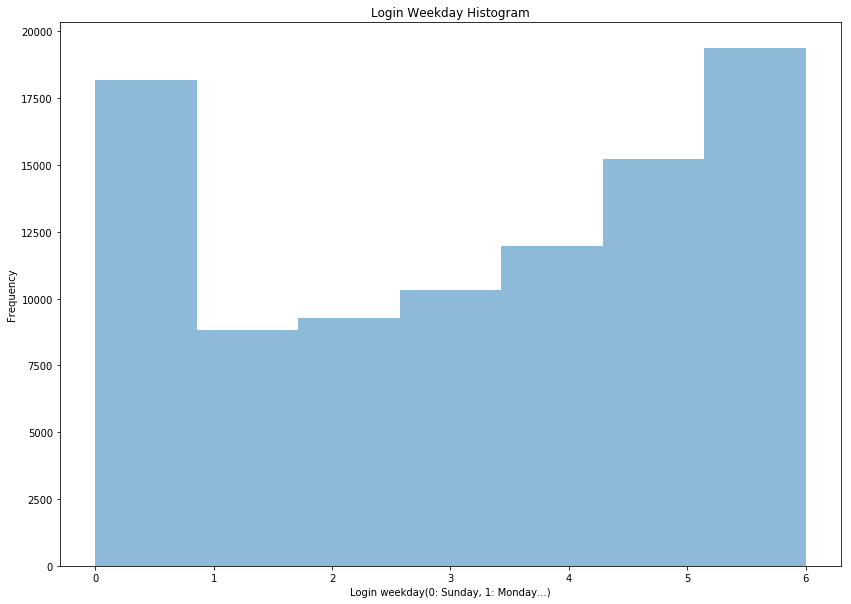

In [6]:
fig = plt.figure(figsize=(14, 10))
plt.hist(weekday,bins=7,alpha=0.5)
plt.title("Login Weekday Histogram")
plt.xlabel("Login weekday(0: Sunday, 1: Monday...)")
plt.ylabel("Frequency")
plt.savefig('Login weekday histogram')
plt.show()

### The weekday histogram above shows that during the weekend the peak logins happened. 

###  ts is the time in minutes of the login timestamp that is converted into minutes. There are 96 bins with size of bin = 15 minutes. And the histogram is plotted using bin size of 15 minutes for 24 hours daily cycle.

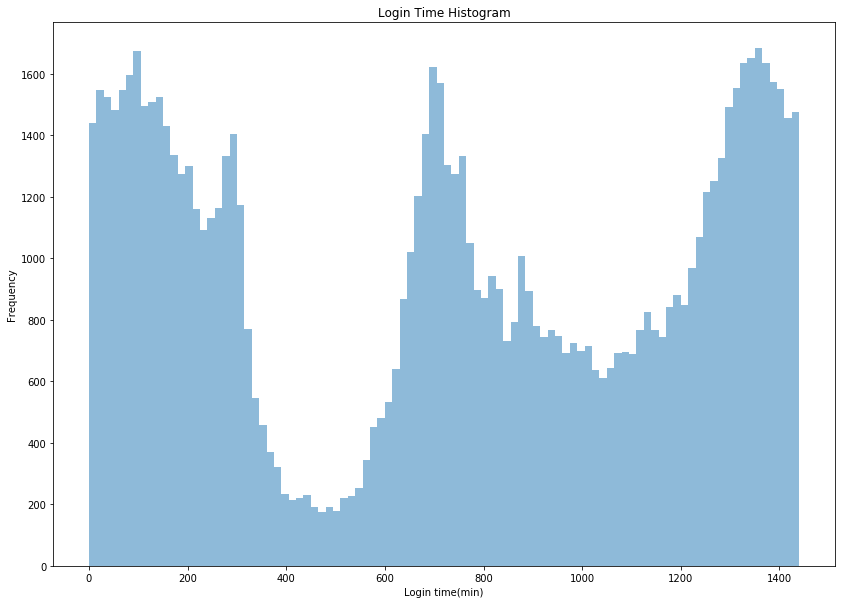

In [7]:
fig = plt.figure(figsize=(14, 10))
plt.hist(ts,bins=96,alpha=0.5)
plt.title("Login Time Histogram")
plt.xlabel("Login time(min)")
plt.ylabel("Frequency")
plt.savefig('Login time histogram')
plt.show()

In [8]:
peak1 = (ts >= 0) & (ts <= 300)
peak1= len(ts[peak1]) /len(ts) *100
print("Percetage of login_in from 0-5:00 is : %.1f"% peak1) 
peak2 = (ts >= 650) & (ts <= 800)
peak2= len(ts[peak2]) /len(ts)*100
print("Percetage of login_in from 10:50-13:20 is : %.1f"% peak2) 
peak3 = (ts >= 1250) & (ts <= 1440)
peak3= len(ts[peak3]) /len(ts) *100
print("Percetage of login_in from 20:50-23:59 is : %.1f"% peak3) 
low = (ts >= 400) & (ts <= 600)
low= len(ts[low]) /len(ts) *100
print("Percetage of login_in from 6:40-10:00 is : %.1f"% low) 

Percetage of login_in from 0-5:00 is : 30.0
Percetage of login_in from 10:50-13:20 is : 13.6
Percetage of login_in from 20:50-23:59 is : 20.5
Percetage of login_in from 6:40-10:00 is : 3.7


### The histogram indicates that there are 3 peak demanding time frames for daily cycle:   
#### 1) There are about 30% logins in the time window 0-5 am;   
#### 2) There are about 13.6% logins in the time 10:50 to 13:20 and 
#### 3) There are 20.5% logins during the 20:50 to 23:59. 
#### Therefore we conclude that login activites happened during night time from 10:50 till 5:00 takes about 50.5%. 

#### On the other hand, there are only 3.7% logins during the usual business time 6:40-10:00.

# Part 2: Experiment and metrics design

### 1. The profit of driving in both cities after reimbursement is to be metric of the study.    

### 2. Two groups of drivers(the same number drivers in each group) are included in the study. One group of drivers(group A) are all signed up for both city driving program. The other group all drivers(group B) are only drivers limited to their own city. After reimbursement for group A the net income for drivers in this group are compared to group B’s drivers. Then a t-test is conducted to compare profits for these two groups at p level of 0.05.                                                                                                         

### 3. The results from study may be follows:                                                                                                                                if profit for A is greater than that of group B, this means the experiment of reimbursement is a good way to promote the exchange of drivers in both cities. On the other hand, the profit for A is equal or less than that of the group B, this means the reimbursement of cost is not an effective way to promote the exchange of drivers. 


# Part 3: Predictive modeling

In [9]:
data2 = json.load((open('ultimate_data_challenge.json')))

In [10]:
data2[0].keys()

dict_keys(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver', 'avg_surge', 'last_trip_date', 'phone', 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver'])

In [11]:
df = pd.DataFrame(data2, columns = ['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver', 'avg_surge', 'last_trip_date', 'phone', 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [13]:
df = df[df['avg_rating_of_driver'].notnull()]
df = df[df['phone'].notnull()]
df = df[df['avg_rating_by_driver'].notnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 12 columns):
city                      41445 non-null object
trips_in_first_30_days    41445 non-null int64
signup_date               41445 non-null object
avg_rating_of_driver      41445 non-null float64
avg_surge                 41445 non-null float64
last_trip_date            41445 non-null object
phone                     41445 non-null object
surge_pct                 41445 non-null float64
ultimate_black_user       41445 non-null bool
weekday_pct               41445 non-null float64
avg_dist                  41445 non-null float64
avg_rating_by_driver      41445 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.8+ MB


In [14]:

start_date = pd.to_datetime(df['signup_date'], format='%Y-%m-%d')
#print(start_date)
end_date = start_date + datetime.timedelta(days=180)
end_date
df['active'] = pd.to_datetime(df['last_trip_date'], format='%Y-%m-%d')+ datetime.timedelta(days=31) >=  end_date
print(df.shape[0])

print(df[df['active']==True].shape[0])

df.loc[df['active']==True,'active'] = 1
df.loc[df['active']==False,'active'] = 0
#df.active
# retain rate
retain = (df[df['active']==True].shape[0])/ df.shape[0] * 100
print('retain rate is : %.2f percent'%retain)

41445
12225
retain rate is : 29.50 percent


### the retain rate is 29.5% if consider the 6 months as the timeframe

                        trips_in_first_30_days  avg_rating_of_driver  \
trips_in_first_30_days                1.000000             -0.011849   
avg_rating_of_driver                 -0.011849              1.000000   
avg_surge                            -0.000262             -0.022209   
surge_pct                             0.005370             -0.001696   
ultimate_black_user                   0.115066             -0.003292   
weekday_pct                           0.055556              0.012975   
avg_dist                             -0.136471              0.034877   
avg_rating_by_driver                 -0.045788              0.122413   
active                                0.197674             -0.007740   

                        avg_surge  surge_pct  ultimate_black_user  \
trips_in_first_30_days  -0.000262   0.005370             0.115066   
avg_rating_of_driver    -0.022209  -0.001696            -0.003292   
avg_surge                1.000000   0.795737            -0.070613   
sur

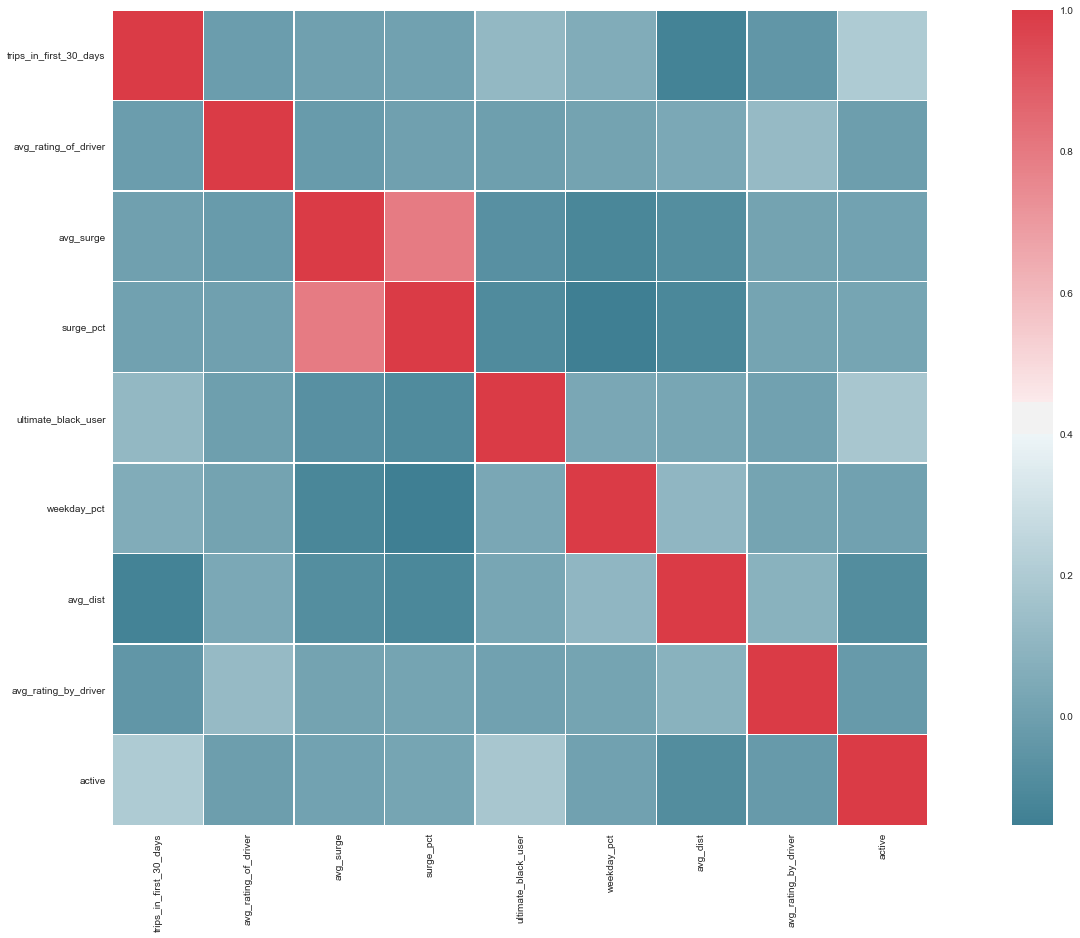

In [15]:

#following are calculations for correlation matrix between all vaiables of dataset data

sns.set(style="white")
df_corr = df[:]

# Compute the correlation matrix
corr = df_corr.dropna().corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(30, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, ax=ax)

print(corr)

###  Above correlation map shows the correlation between surge_pct  and avg_surge is 0.796 which means we need drop one. 

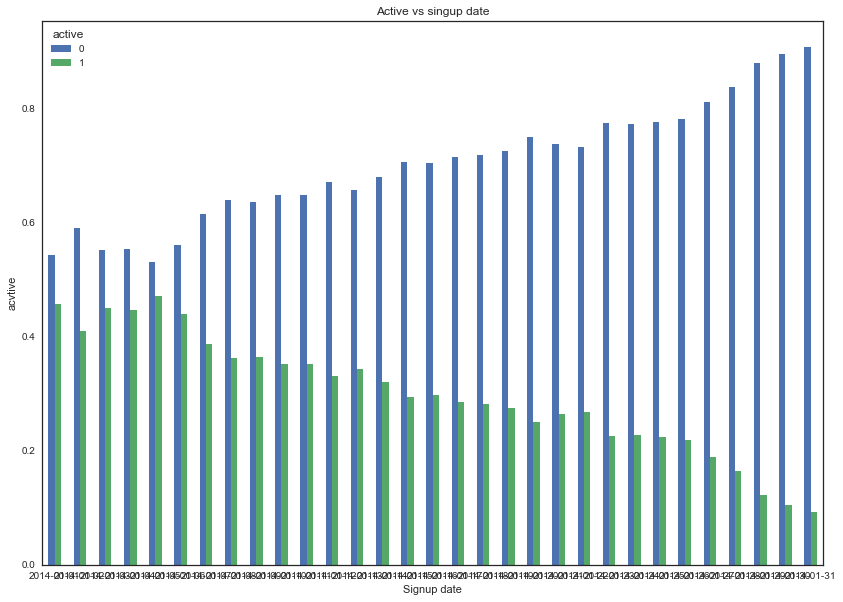

In [16]:
#pd.crosstab(data['agerange'],data.y).plot(kind='bar',figsize=(14, 10))
table = pd.crosstab(df.signup_date,df.active)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar',figsize=(14, 10))
plt.title('Active vs singup date')
plt.xlabel('Signup date')
plt.xticks(rotation = 0)
plt.ylabel('acvtive')
plt.savefig('active_signup')

### It obvious show that going towards the end of January for the signup date, the active rate decrease in the end of the six months.

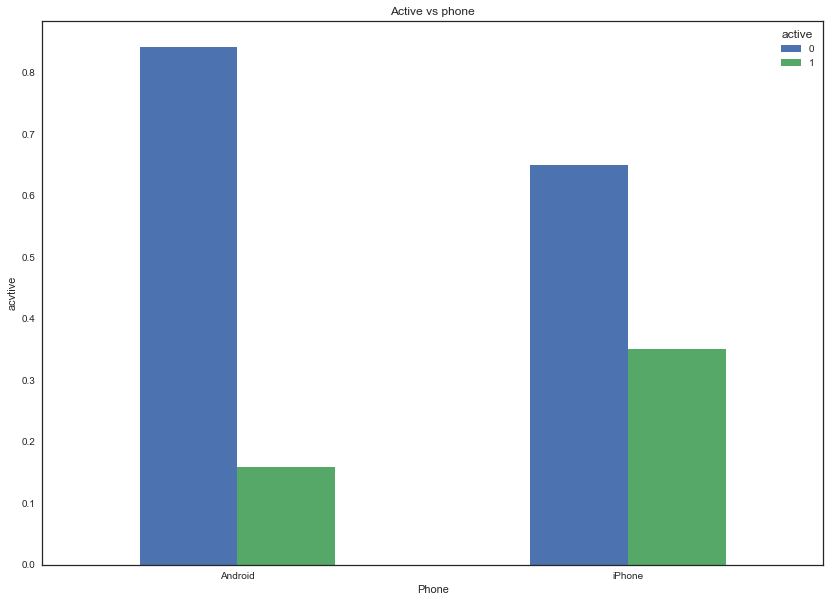

In [17]:
#pd.crosstab(data['agerange'],data.y).plot(kind='bar',figsize=(14, 10))
table = pd.crosstab(df.phone,df.active)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar',figsize=(14, 10))
plt.title('Active vs phone')
plt.xlabel('Phone')
plt.xticks(rotation = 0)
plt.ylabel('acvtive')
plt.savefig('active_phone')

### it seems that the iphone user have higher retain rate than android users.

In [18]:
data_dmy = pd.get_dummies(df, columns =['phone','city'],drop_first=True)
data_vars=data_dmy.columns.values.tolist()
removal_vars = ['avg_surge','signup_date','last_trip_date']
keep=[i for i in data_vars if i not in removal_vars]
final_data = data_dmy[keep]

final_data.columns.values

array(['trips_in_first_30_days', 'avg_rating_of_driver', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'active', 'phone_iPhone',
       "city_King's Landing", 'city_Winterfell'], dtype=object)

In [19]:
final_data_vars = final_data.columns.values.tolist()

y = ['active']
X = [i for i in final_data_vars if i not in y]

In [20]:
data_dmy[X].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 10 columns):
trips_in_first_30_days    41445 non-null int64
avg_rating_of_driver      41445 non-null float64
surge_pct                 41445 non-null float64
ultimate_black_user       41445 non-null bool
weekday_pct               41445 non-null float64
avg_dist                  41445 non-null float64
avg_rating_by_driver      41445 non-null float64
phone_iPhone              41445 non-null uint8
city_King's Landing       41445 non-null uint8
city_Winterfell           41445 non-null uint8
dtypes: bool(1), float64(5), int64(1), uint8(3)
memory usage: 2.4 MB


In [21]:

X_train, X_test, y_train, y_test = train_test_split(data_dmy[X],data_dmy[y], test_size=0.3, random_state=0)

In [22]:

# Setup the hyperparameter grid
c_space = np.logspace(-3, 4, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# Instantiate a logistic regression classifier: logreg

logreg = LogisticRegression(fit_intercept = False,random_state=0)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=10)

# Fit it to the data
logreg_cv.fit(X_train, y_train.values.ravel())

# Print the tuned parameter and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 0.03162277660168379, 'penalty': 'l2'}
Best score is 0.7311364654786116


In [23]:
LogReg = LogisticRegression(fit_intercept = False, C = 0.03162277660168379,random_state=0)
LogReg.fit(X_train.astype(float), y_train.astype(float))
score = LogReg.score(X_train.astype(float), y_train.astype(float))
print('Accuracy of logistic regression classifier on training set: {:.2f}\n'.format(score))

y_pred = LogReg.predict(X_test)
print('Accuracy of logistic regression classifier on testing set: {:.2f}\n'.format(LogReg.score(X_test, y_test)))

print(LogReg.coef_)

Accuracy of logistic regression classifier on training set: 0.73

Accuracy of logistic regression classifier on testing set: 0.73

[[ 8.55140423e-02 -1.13899675e-01  3.12118751e-03  6.98315577e-01
  -6.06266463e-04 -4.07396973e-02 -3.75407583e-01  8.78619912e-01
   1.17309690e+00  4.09019006e-01]]


C:\Users\VT\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### The acurracy of the Logistic regression for train and test datasets are both 0.73. 

In [24]:
columns = data_dmy[X].columns.values.tolist()
print(columns)
df_x = pd.DataFrame(X_train, columns =columns) 

['trips_in_first_30_days', 'avg_rating_of_driver', 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'phone_iPhone', "city_King's Landing", 'city_Winterfell']


Importance of features: 
  [[0.15372393744533946, 0.030786249085241316, 0.024900211688118477, 0.14875341431972186, 0.009247021677342976, 0.09192414376978447, 0.06676819210428968, 0.17489536686172003, 0.2096478454752346, 0.08935361757320719]]


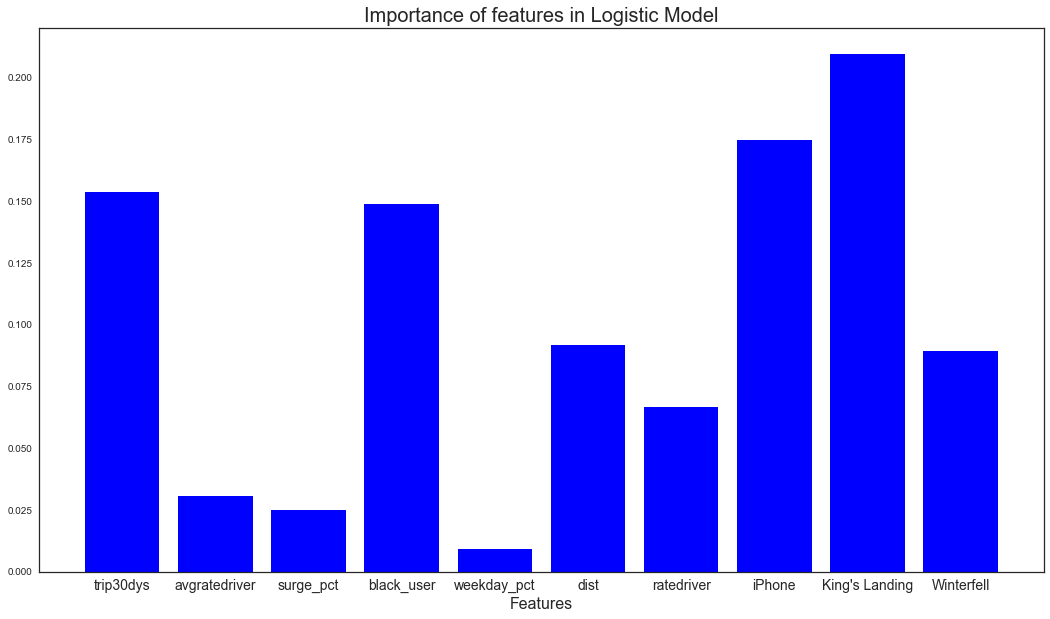

In [25]:
imp = abs(list(np.std(df_x))*LogReg.coef_)
importance = imp.tolist()

s = 0
for row in importance:  #sum up all members in the list
    for elem in row:
        s += elem
rel_imp = imp/s
imp_list = rel_imp.tolist() # normalized imprtance
#columns = X_train.columns.tolist()
columns = ['trip30dys', 'avgratedriver', 'surge_pct', 'black_user', 'weekday_pct', 'dist', 'ratedriver', 'iPhone', "King's Landing", 'Winterfell']
y_pos = np.arange(len(columns))

print("Importance of features: \n ",rel_imp.tolist())

fig = plt.figure(figsize=(18, 10))
plt.xticks(y_pos, columns,fontsize=14)
plt.xlabel('Features',fontsize=16)
plt.title('Importance of features in Logistic Model', fontsize =20)
b = [num for elem in rel_imp.tolist() for num in elem] # convert array into a list
plt.bar(y_pos, b, align='center',color='blue')
plt.savefig('Importance feature_log Reg')

### The above importance of features tell us that the King's Landing, iphone and trips in the first 30 days and black user are first 4 important variables for prediction of active status the retains.

### The results for the King's Landing should be looked in more detail comparing with other cities. iphone users are also needed to be compared to android users to see if the apps they use are very different. 